In [2]:
# Basics: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# Load CSV (use the CSV available in the workspace)
df = pd.read_csv('Dataset_Simulated_Price_swaption.csv')
# Parse Date column and set index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')
    df = df.set_index('Date').sort_index()
else:
    df.index = pd.to_datetime(df.index, errors='coerce')

print('shape:', df.shape)
df.head()

shape: (500, 224)


,Tenor : 1; Maturity : 0.0833333333333333,Tenor : 2; Maturity : 0.0833333333333333,Tenor : 3; Maturity : 0.0833333333333333,Tenor : 4; Maturity : 0.0833333333333333,Tenor : 5; Maturity : 0.0833333333333333,Tenor : 6; Maturity : 0.0833333333333333,Tenor : 7; Maturity : 0.0833333333333333,Tenor : 8; Maturity : 0.0833333333333333,Tenor : 9; Maturity : 0.0833333333333333,Tenor : 10; Maturity : 0.0833333333333333,...,Tenor : 5; Maturity : 30,Tenor : 6; Maturity : 30,Tenor : 7; Maturity : 30,Tenor : 8; Maturity : 30,Tenor : 9; Maturity : 30,Tenor : 10; Maturity : 30,Tenor : 15; Maturity : 30,Tenor : 20; Maturity : 30,Tenor : 25; Maturity : 30,Tenor : 30; Maturity : 30
Date,,,,,,,,,,,,,,,,,,,,,
2050-01-01,0.028565,0.038700,0.040127,0.040762,0.040466,0.038953,0.037553,0.036768,0.036646,0.035595,...,0.331053,0.329056,0.330997,0.324676,0.325758,0.322393,0.345859,0.359162,0.346670,0.337670
2050-01-02,0.029334,0.039499,0.040982,0.041638,0.041336,0.039815,0.038397,0.037631,0.037504,0.036437,...,0.336319,0.334434,0.336568,0.330244,0.331462,0.328144,0.351816,0.365197,0.350993,0.340822
2050-01-03,0.028696,0.038816,0.040328,0.041042,0.040804,0.039329,0.037968,0.037216,0.037107,0.036062,...,0.333634,0.331707,0.333800,0.327487,0.328710,0.325436,0.348915,0.362236,0.348652,0.339027
2050-01-05,0.030854,0.041536,0.043035,0.043605,0.043241,0.041556,0.039977,0.039167,0.038968,0.037793,...,0.336884,0.335106,0.337548,0.331279,0.332811,0.329771,0.353246,0.366100,0.351404,0.340465
2050-01-06,0.030406,0.041174,0.042681,0.043266,0.042937,0.041253,0.039685,0.038867,0.038667,0.037492,...,0.333249,0.331426,0.333830,0.327580,0.329123,0.326146,0.349390,0.362048,0.348331,0.338022


In [4]:
# Choose a single series to predict — take the first numeric column as a prototype
target_col = df.columns[0]
print('target column:', target_col)
series = pd.to_numeric(df[target_col], errors='coerce').dropna()
series.head()

target column: Tenor : 1; Maturity : 0.0833333333333333


Date
2050-01-01    0.028565
2050-01-02    0.029334
2050-01-03    0.028696
2050-01-05    0.030854
2050-01-06    0.030406
Name: Tenor : 1; Maturity : 0.0833333333333333, dtype: float64

In [5]:
# Create lag features (simple autoregressive features)
lags = 5
data = pd.DataFrame({'y': series})
for i in range(1, lags+1):
    data[f'lag_{i}'] = series.shift(i)
data = data.dropna()
print('prepared rows:', len(data))
data.head()

prepared rows: 495


,y,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2050-01-08,0.030075,0.030406,0.030854,0.028696,0.029334,0.028565
2050-01-09,0.029030,0.030075,0.030406,0.030854,0.028696,0.029334
2050-01-11,0.029700,0.029030,0.030075,0.030406,0.030854,0.028696
2050-01-12,0.027885,0.029700,0.029030,0.030075,0.030406,0.030854
2050-01-14,0.029263,0.027885,0.029700,0.029030,0.030075,0.030406


In [6]:
# Split sequentially: first 80% train, last 20% test (time-series-safe)
split_idx = int(len(data) * 0.8)
train = data.iloc[:split_idx]
test = data.iloc[split_idx:]
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
y_test = test['y']
print('train/test sizes:', X_train.shape, X_test.shape)


train/test sizes: (396, 5) (99, 5)


In [7]:
# Train a simple RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
# rmse = mean_squared_error(y_test, preds, squared=False)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print(f'RMSE on test set: {rmse:.6f}')


RMSE on test set: 0.001197


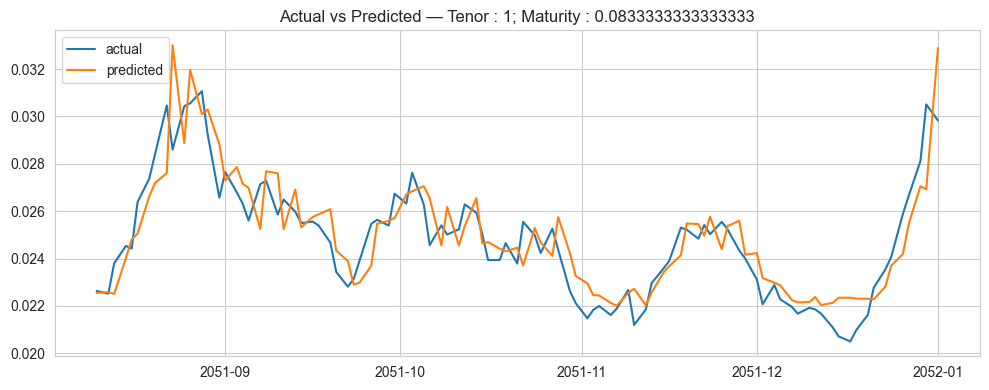

In [8]:
# Plot actual vs predicted (test range)
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label='actual')
plt.plot(y_test.index, preds, label='predicted')
plt.title(f'Actual vs Predicted — {target_col}')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Quick feature importance (optional)
try:
    importances = model.feature_importances_
    fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    print(fi)
except Exception as e:
    print('could not compute feature importances:', e)


lag_1    0.906841
lag_2    0.058732
lag_3    0.017948
lag_4    0.008557
lag_5    0.007922
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# === 1. データ読み込み ===
df = pd.read_csv("Dataset_Simulated_Price_swaption.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').sort_index()

# === 2. 列名から tenor / maturity を抽出 ===
import re
tenor_maturity = []
for col in df.columns:
    m = re.search(r'Tenor\s*:\s*(\d+).*?Maturity\s*:\s*([\d.]+)', col)
    if m:
        tenor = float(m.group(1))
        maturity = float(m.group(2))
        tenor_maturity.append((col, tenor, maturity))
    else:
        # データ形式が "Tenor1_Maturity0.0833" のような場合はこちら
        m = re.search(r'Tenor(\d+)_Maturity([\d.]+)', col)
        if m:
            tenor = float(m.group(1))
            maturity = float(m.group(2))
            tenor_maturity.append((col, tenor, maturity))

# === 3. 時系列特徴量を作成 ===
lags = 5
rows = []

for col, tenor, maturity in tenor_maturity:
    series = pd.to_numeric(df[col], errors='coerce').dropna()
    data = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = series.shift(i)
    data['tenor'] = tenor
    data['maturity'] = maturity
    data = data.dropna()
    rows.append(data)

# 全系列を結合
all_data = pd.concat(rows)

In [ ]:
# # === 4. 訓練データとテストデータ ===
# split_idx = int(len(all_data) * 0.8)
# train = all_data.iloc[:split_idx]
# test = all_data.iloc[split_idx:]

# X_train = train.drop('y', axis=1)
# y_train = train['y']
# X_test = test.drop('y', axis=1)
# y_test = test['y']

# === 4. 訓練データとテストデータ（日付インデックス基準） ===
# 日付でソート
all_data = all_data.sort_index()

# 8割の位置の日付を取得
split_date = all_data.index[int(len(all_data) * 0.8)]

# 日付を基準にデータを分割
train = all_data[all_data.index <= split_date]
test = all_data[all_data.index > split_date]

# 特徴量と目的変数を分割
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
X_test_tnr_1_0_mtr_0_0833 = X_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
y_test = test['y']
y_test_tnr_1_0_mtr_0_0833 = y_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]

print(f"📆 Split date: {split_date}")
print(f"✅ Train size: {len(train)}, Test size: {len(test)}")

📆 Split date: 2051-08-10 00:00:00
✅ Train size: 88928, Test size: 21952


In [37]:
# === 5. ランダムフォレスト訓練 ===
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
y_pred = model.predict(X_test)
y_pred_tnr_1_0_mtr_0_0833 = model.predict(X_test_tnr_1_0_mtr_0_0833)

In [45]:
# === 6. 評価 ===
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.6f}")

mse_tnr_1_0_mtr_0_0833 = mean_squared_error(y_test_tnr_1_0_mtr_0_0833, y_pred_tnr_1_0_mtr_0_0833)
print(f"MSE (tenor=1.0, maturity=0.0833): {mse_tnr_1_0_mtr_0_0833:.6f}")

MSE: 0.000014
MSE (tenor=1.0, maturity=0.0833): 0.000001


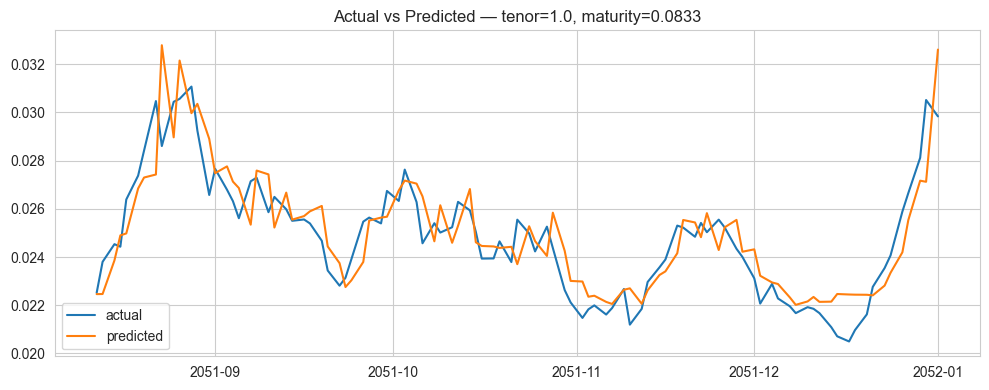

In [ ]:
# 作図
# plt.figure(figsize=(10,4))
# plt.plot(y_test.index, y_test.values, label='actual')
# plt.plot(y_test.index, preds, label='predicted')
# plt.title(f'Actual vs Predicted — {target_col}')
# plt.legend()
# plt.tight_layout()
# plt.show()
plt.figure(figsize=(10,4))
plt.plot(y_test_tnr_1_0_mtr_0_0833.index, y_test_tnr_1_0_mtr_0_0833.values, label='actual')
plt.plot(y_test_tnr_1_0_mtr_0_0833.index, y_pred_tnr_1_0_mtr_0_0833, label='predicted')
plt.title(f'Actual vs Predicted — tenor=1.0, maturity=0.0833')
plt.legend()
plt.tight_layout()
plt.show()
